# Project CVAE on MNIST datas

In [16]:
# Imports
import random
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Loading Fashion-MNIST datasets
# Note: to improve speed we could save images as flatten images (using tranform for example)
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

In [3]:
# Global values
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
MAX_EPOCHS = 10
LEARNING_RATE = 1e-3
CLASSES_TO_IDX = train_dataset.class_to_idx
FEATURE_SIZE = train_dataset.data[0].shape[0]
CLASS_SIZE = 10
LATENT_SIZE = 10

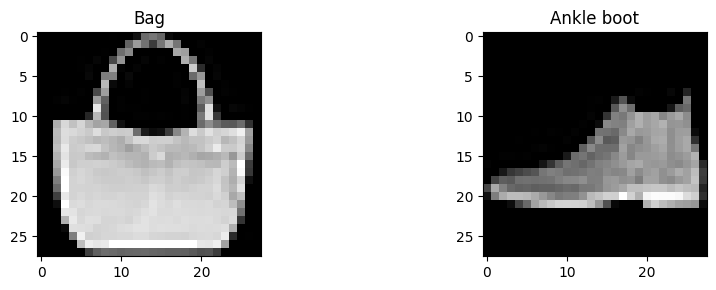

In [4]:
# Print the first image of each dataset
# Note: Do not run it after splitting datas into validation and test sets
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

axs[0].imshow(train_dataset.data[100], cmap='gray')
axs[0].set_title(f"{list(CLASSES_TO_IDX.keys())[train_dataset.targets[100]]}")

axs[1].imshow(test_dataset.data[0], cmap='gray')
axs[1].set_title(f"{list(CLASSES_TO_IDX.keys())[test_dataset.targets[0]]}")

plt.tight_layout()
plt.show()

In [5]:
# Split test between validation and test
val_size = int(test_dataset.data.shape[0] / 2)
test_size = test_dataset.data.shape[0] - val_size
test_dataset, val_dataset = random_split(test_dataset, [test_size, val_size])

# Some prints
print(f"Train dataset size: {len(train_dataset.data)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Makes dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Train dataset size: 60000
Validation dataset size: 5000
Test dataset size: 5000


In [6]:
# See https://github.com/unnir/cVAE/blob/master/cvae.py
class CVAE(nn.Module):
    def __init__(self, feature_size, latent_size, class_size):
        super(CVAE, self).__init__()
        self.feature_size = feature_size
        self.class_size = class_size

        # encode
        self.fc1  = nn.Linear(feature_size * feature_size + class_size, 400)
        self.fc21 = nn.Linear(400, latent_size)
        self.fc22 = nn.Linear(400, latent_size)

        # decode
        self.fc3 = nn.Linear(latent_size + class_size, 400)
        self.fc4 = nn.Linear(400, feature_size * feature_size)

        self.elu = nn.ELU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x, c): # Q(z|x, c)
        inputs = torch.cat([x, c], 1)
        h1 = self.elu(self.fc1(inputs))
        z_mu = self.fc21(h1)
        z_var = self.fc22(h1)
        return z_mu, z_var

    def sample(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z, c): # P(x|z, c)
        inputs = torch.cat([z, c], 1)
        h3 = self.elu(self.fc3(inputs))
        recon = self.sigmoid(self.fc4(h3))
        return recon.view(inputs.size(0), 1, self.feature_size, self.feature_size)

    def forward(self, x, c):
        x = x.view(x.size(0), -1)
        mu, logvar = self.encode(x, c)
        z = self.sample(mu, logvar)
        return self.decode(z, c), mu, logvar

In [7]:
def loss_function(recon_x, x, mu, logvar, beta=1):
    recon_x = recon_x.view(recon_x.size(0), -1)
    x = x.view(x.size(0), -1)
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD

In [8]:
def one_hot(labels, class_size):
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return targets.to(DEVICE)

In [9]:
cvae = CVAE(FEATURE_SIZE, LATENT_SIZE, CLASS_SIZE)
cvae.to(DEVICE)
optimizer = optim.Adam(cvae.parameters(), lr=LEARNING_RATE)

for epoch in range(1, MAX_EPOCHS + 1):

    # Training part
    cvae.train()
    running_train_loss = 0.0
    t_train = tqdm(train_loader, desc=f"Epoch {epoch}/{MAX_EPOCHS} Training")
    for data, labels in t_train:
        data, labels = data.to(DEVICE), labels.to(DEVICE)
        labels = one_hot(labels, CLASS_SIZE)
        recon_batch, mu, logvar = cvae(data, labels)
        optimizer.zero_grad()
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
    train_loss = running_train_loss / len(train_loader.dataset)

    # Validation part
    cvae.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for validation
        running_val_loss = 0.0
        t_val = tqdm(val_loader, desc=f"Epoch {epoch}/{MAX_EPOCHS} Validation")
        for data, labels in t_val:
            data, labels = data.to(DEVICE), labels.to(DEVICE)
            labels = one_hot(labels, CLASS_SIZE)
            recon_batch, mu, logvar = cvae(data, labels)            
            loss = loss_function(recon_batch, data, mu, logvar)

            running_val_loss += loss.item()

    val_loss = running_val_loss / len(val_loader.dataset)
    
    print(f'Epoch {epoch}, Training loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}')

# Saving part (if needed)
torch.save(cvae.state_dict(), 'cvae_weights.pth')

Epoch 1/10 Validation: 100%|████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.19it/s]


Epoch 1, Training loss: 266.8504, Validation loss: 255.3258


Epoch 2/10 Validation: 100%|████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.51it/s]


Epoch 2, Training loss: 250.5958, Validation loss: 249.5099


Epoch 3/10 Validation: 100%|████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.63it/s]


Epoch 3, Training loss: 246.6532, Validation loss: 246.6979


Epoch 4/10 Validation: 100%|████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.08it/s]


Epoch 4, Training loss: 244.6141, Validation loss: 245.3394


Epoch 5/10 Validation: 100%|████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.40it/s]


Epoch 5, Training loss: 243.2539, Validation loss: 244.3661


Epoch 6/10 Validation: 100%|████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.35it/s]


Epoch 6, Training loss: 242.3781, Validation loss: 243.5865


Epoch 7/10 Validation: 100%|████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.48it/s]


Epoch 7, Training loss: 241.6035, Validation loss: 243.4737


Epoch 8/10 Validation: 100%|████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.92it/s]


Epoch 8, Training loss: 241.0807, Validation loss: 242.7847


Epoch 9/10 Validation: 100%|████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 83.59it/s]


Epoch 9, Training loss: 240.6280, Validation loss: 242.4013


Epoch 10/10 Validation: 100%|███████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 99.93it/s]

Epoch 10, Training loss: 240.2338, Validation loss: 241.4732


Testing...: 100%|███████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 75.50it/s]


Test loss: 242.00343212890624 -- MSE: 12.85520365447998


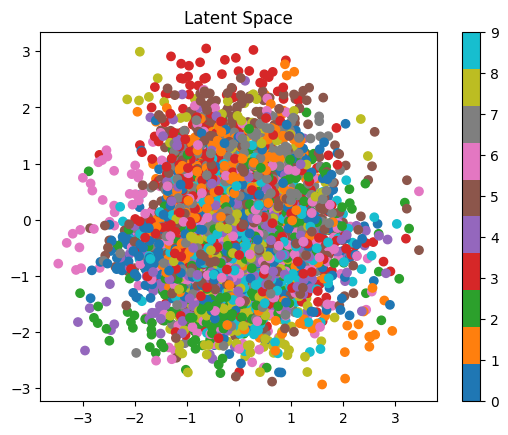

In [10]:
# Loading model
cvae = CVAE(FEATURE_SIZE, LATENT_SIZE, CLASS_SIZE)
cvae.to(DEVICE)
cvae.load_state_dict(torch.load('cvae_weights.pth', weights_only=True))
cvae.eval()

# Plot
fig, ax = plt.subplots()
scatter = ax.scatter([], [], c=[], cmap='tab10', vmin=0, vmax=9)

with torch.no_grad():
    running_test_loss = 0.0
    total_mse = 0.0
    number_images = 0
    residuals_sum = 0
    t_test = tqdm(test_loader, desc="Testing...")
    for data, labels in t_test:
        data, labels = data.to(DEVICE), labels.to(DEVICE)
        labels = one_hot(labels, CLASS_SIZE)
        recon_batch, mu, logvar = cvae(data, labels) 
        loss = loss_function(recon_batch, data, mu, logvar)
        mse_value = F.mse_loss(recon_batch, data, reduction='sum') 
        total_mse += mse_value.item()
        residuals_sum += torch.abs(data - recon_batch).sum(dim=0) # (1, 28, 28) where 1 is the channel number
        number_images += labels.size(0)

        running_test_loss += loss.item()

        # Plot part
        mu, labels = mu.cpu(), labels.cpu()
        scatter = ax.scatter(mu[:,0], mu[:,1], c=[labels.argmax(dim=1)], cmap='tab10', vmin=0, vmax=9)        
        
test_loss = running_test_loss / len(test_loader.dataset)
MSE = total_mse / number_images
print(f"Test loss: {test_loss} -- MSE: {MSE}")

plt.colorbar(scatter)
plt.title("Latent Space")
plt.show()

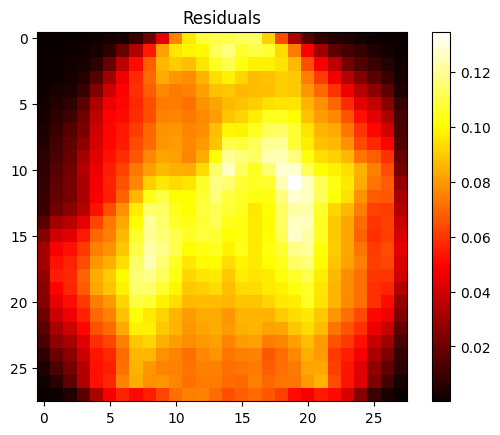

In [11]:
# Plot residuals
residuals_mean = residuals_sum / number_images
residuals_mean_np = residuals_mean.cpu().numpy().squeeze()  # (28, 28) The squeeze is used to delete channel dim

plt.imshow(residuals_mean_np, cmap='hot')
plt.title('Residuals')
plt.colorbar()
plt.show()

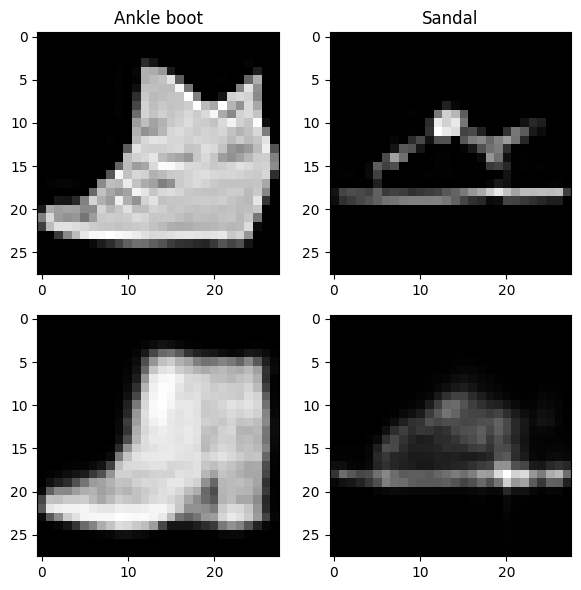

In [21]:
# Makes some plots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6,6))

loader_iter = iter(test_loader)

data1, labels1 = next(loader_iter)
data1, labels1 = data1.to(DEVICE), labels1.to(DEVICE)
labels1 = one_hot(labels1, CLASS_SIZE)
recon1, _, _ = cvae(data1, labels1)

data2, labels2 = next(loader_iter)
data2, labels2 = data2.to(DEVICE), labels2.to(DEVICE)
labels2 = one_hot(labels2, CLASS_SIZE)
recon2, _, _ = cvae(data2, labels2)

# Moving back to cpu
data1, data2 = data1.cpu(), data2.cpu()
labels1, labels2 = labels1.cpu(), labels2.cpu()
recon1, recon2 = recon1.detach().cpu(), recon2.detach().cpu()

# Plots
i = random.randint(0, BATCH_SIZE - 1)
axs[0,0].imshow(data1[i].squeeze(), cmap='gray')
axs[0,0].set_title(f"{list(CLASSES_TO_IDX.keys())[labels1[i].argmax()]}")

axs[0,1].imshow(data2[i].squeeze(), cmap='gray')
axs[0,1].set_title(f"{list(CLASSES_TO_IDX.keys())[labels2[i].argmax()]}")

axs[1,0].imshow(recon1[i].squeeze(), cmap='gray')
axs[1,1].imshow(recon2[i].squeeze(), cmap='gray')

plt.tight_layout()
plt.show()